### Research Question 4: Audience Preferences During Crises

In this question we will conduct the analysis by aligning global events such as wars, pandemics, and natural disasters to inspect both short-term and long-term shifts in audience preferences. To do this, we will inspect genre-specific trend analysis to identify immediate spikes in popularity as well as sustained changes over time. Later on, we will visualize the data to highlight both immediate and lasting impacts of global events on movie thematics.

In order to achieve this, we will utilize the Google Search Trends insights that will help us uncover user interest for both general movie genres and thematics and parcular movies in our aggregated movies dataset.

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from matplotlib import pyplot as plt
from src.utils import google_trends as gt
from scipy.stats import pearsonr
import seaborn as sns
from src.utils.genres import get_top_genres, regression_analysis, genres_vs_interest_correlation
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

In [2]:
# Import the movies data
movies = pd.read_table("data/movies_with_summaries.csv", sep=",")

#### 1. Inspecting overall audience preferences

In previous parts we have found the most prominent movies genres. We can check if the distribution of all movie genres reflects the viewer preferences of these same genres.

In [3]:
genres = get_top_genres(movies, 20)

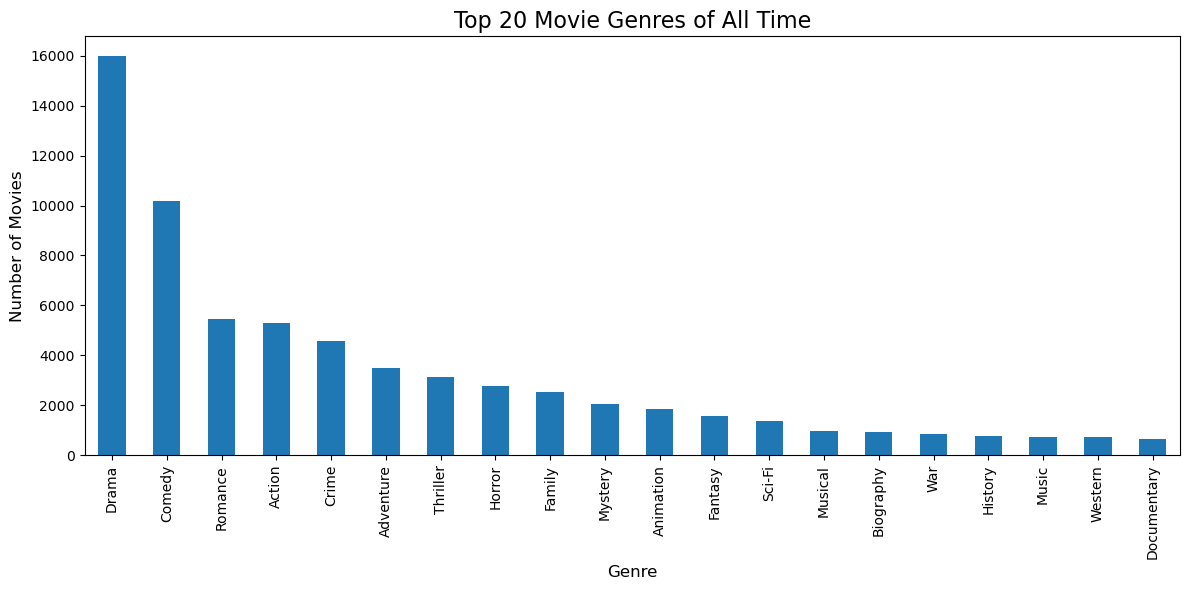

In [4]:
# Plot the distribution of genres
genres.plot(kind='bar', x='Genre', y='Count', legend=False, figsize=(12, 6))
plt.title('Top 20 Movie Genres of All Time', fontsize=16)
plt.ylabel('Number of Movies', fontsize=12)
plt.xlabel('Genre', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

We can now check if the popularity distribution of these genres is reflected in public preference. For this we can use the search trends that would help us understand the public preferences over a period of 2004-2012

In [5]:
# Get the search interest for each genre
all_trends = gt.fetch_historical_interest_for_genres(genres)

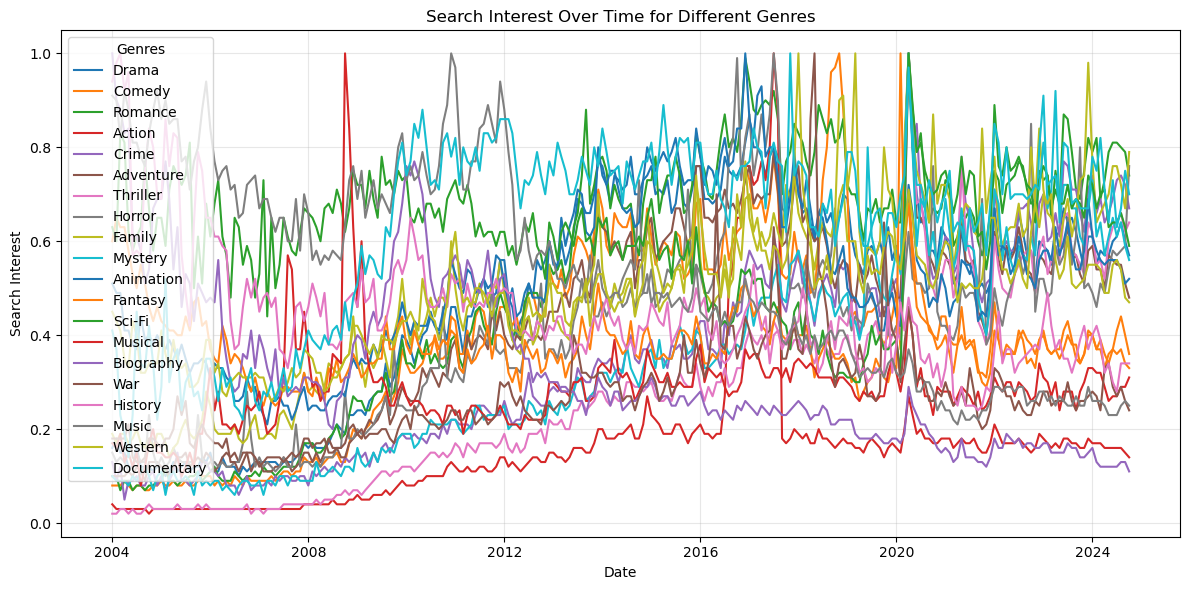

In [6]:
# Create the plot
plt.figure(figsize=(12, 6))
for genre in all_trends['Genre'].unique():
    genre_trend = all_trends[all_trends['Genre'] == genre]
    plt.plot(genre_trend['date'], genre_trend['value'], label=genre)

# Add labels and legend
plt.title('Search Interest Over Time for Different Genres')
plt.xlabel('Date')
plt.ylabel('Search Interest')
plt.legend(title='Genres', loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

The graph is unreadable! (Obviously) Let's try to untangle the trend with a more elegant visualization.

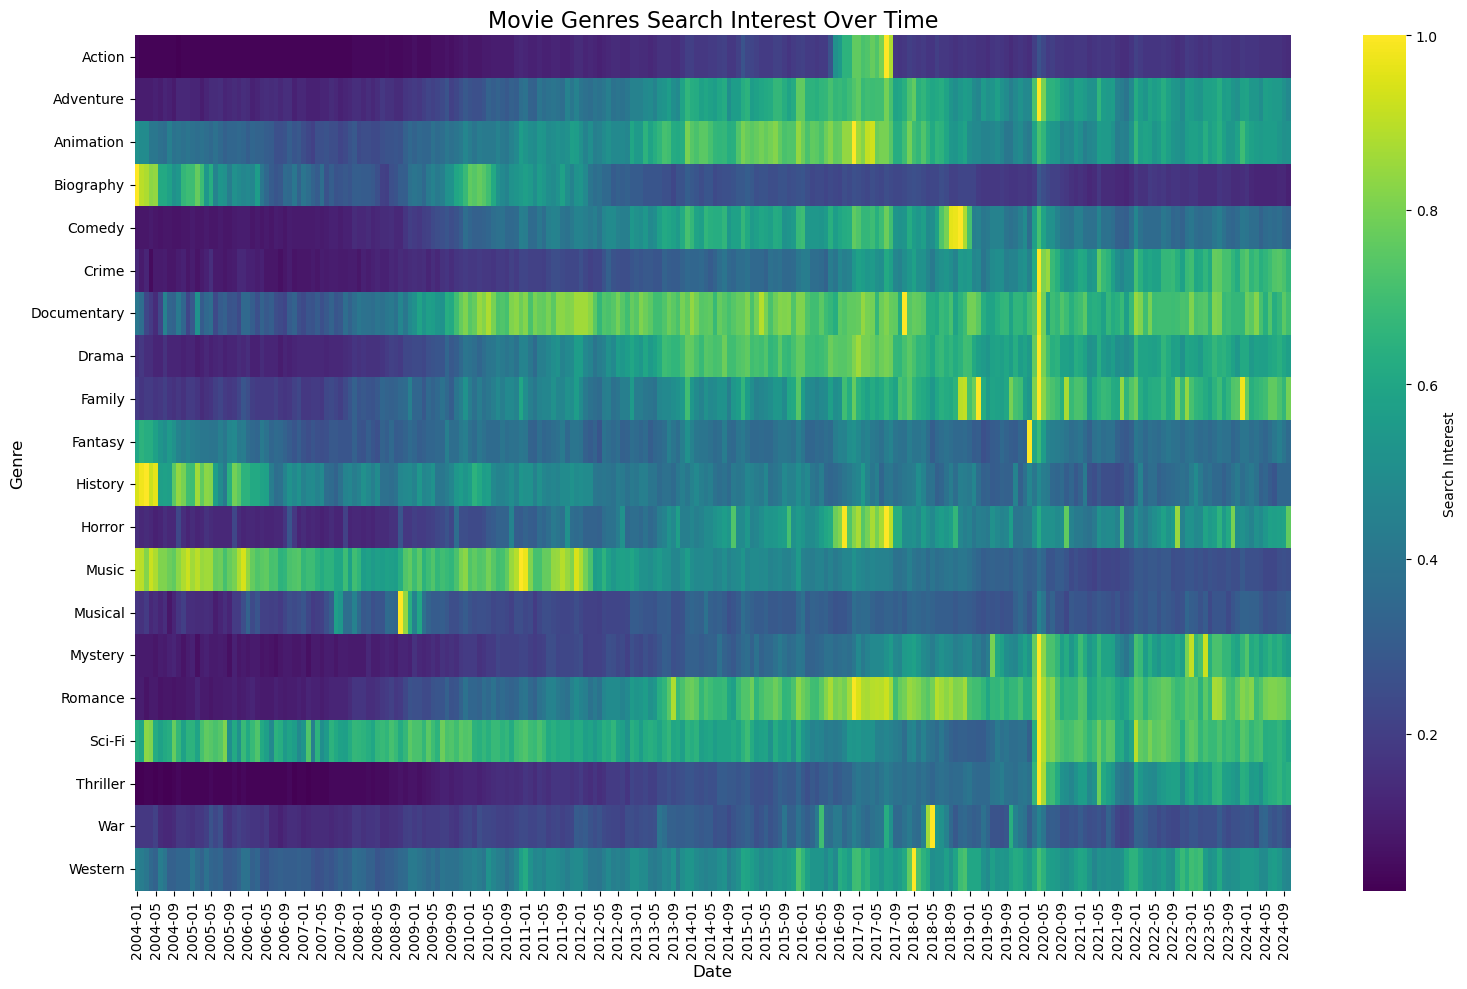

In [7]:
# Pivot the data to create a heatmap
heatmap_data = all_trends.pivot(index='Genre', columns='date', values='value')

# Format the date to show only year and month
heatmap_data.columns = heatmap_data.columns.strftime('%Y-%m')

# Plot the heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(heatmap_data, cmap='viridis', linewidths=0, cbar_kws={'label': 'Search Interest'})

# Add labels and title
plt.title('Movie Genres Search Interest Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Genre', fontsize=12)

# Rotate x-axis labels
plt.xticks(rotation=90, ha='center')

plt.tight_layout()
plt.show()

The first general observation is that the overall movies popularity peaked in 2016-2017 and then again in the beginning of COVID pandemics. The reason for the peak during the pandemics is clear - we were at stuck inside, what else could we do? However, why was there another peak in 2016-2017?

This peak could be explained by two of many other factors: 1) By 2015, streaming had firmly established itself as a dominant force in the entertainment industry. Netflix had expanded to over 190 countries, and Amazon Prime Video had also become a significant player, therefore driving interest in movies. 2) 2016-2018 were among the best years in history with the number of newly released movies as well as box office numbers peaked (Source: [BoxOfficeMojo](https://www.boxofficemojo.com/year/)). Further analysis of such factors would be a particularly interesting idea but is worth another ADA project by itself.

If we zoom out, we can also observe strong seasonality patterns in particular movie genre interest. For example, interest for horror movies generally peaks during Halloween season and Family movies peak around Christmas. 

### 2. Uncovering seasonal trends

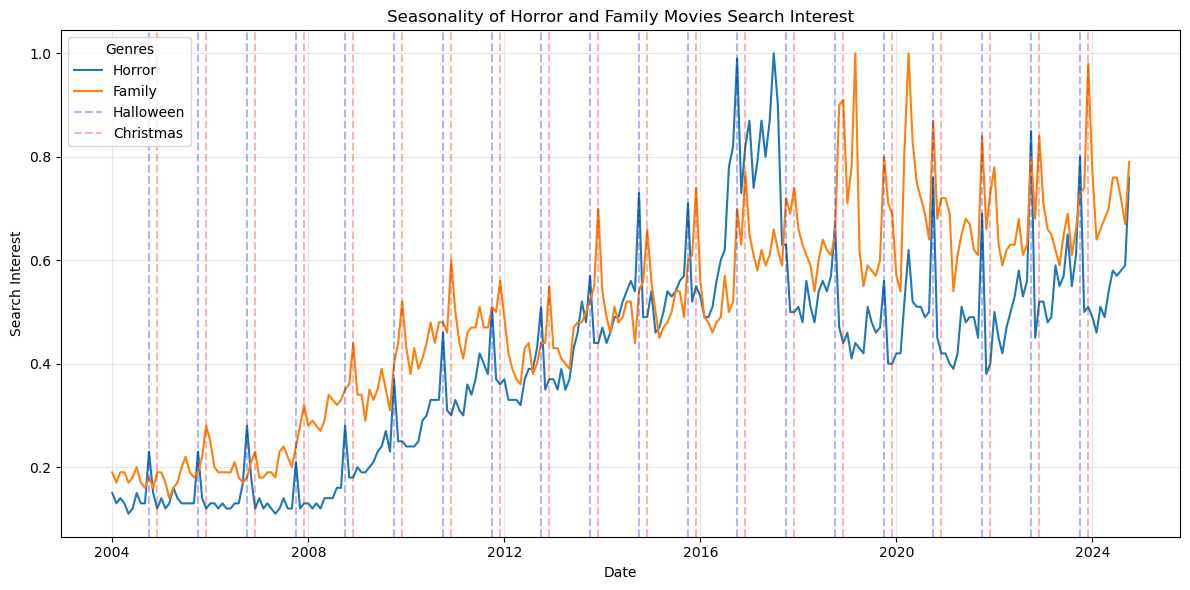

In [8]:
# Plot monthly interest for Horror, Family movies
horror = all_trends[all_trends['Genre'] == 'Horror']
family = all_trends[all_trends['Genre'] == 'Family']

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(horror['date'], horror['value'], label='Horror')
plt.plot(family['date'], family['value'], label='Family')

# Mark Every October and December with a vertical line
for year in range(2004, 2024):
    october = datetime.strptime(f"{year}-10", "%Y-%m")
    plt.axvline(october, color='blue', alpha=0.3, linestyle='--')
    december = datetime.strptime(f"{year}-12", "%Y-%m")
    plt.axvline(december, color='red', alpha=0.3, linestyle='--')

# Add vertical lines to legend
plt.plot([], [], color='blue', alpha=0.3, linestyle='--', label='Halloween')
plt.plot([], [], color='red', alpha=0.3, linestyle='--', label='Christmas')

plt.title('Seasonality of Horror and Family Movies Search Interest')
plt.xlabel('Date')
plt.ylabel('Search Interest')
plt.legend(title='Genres')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

We can now perform a seasonal decomposition analysis to further inspect these patterns for all movie genres. This analysis is performed using an additive seasonality signal:

Y[t] = T[t] + S[t] + e[t]

- Y[t]: Popularity of a movie genre at time t
- T[t]: Trend
- S[t]: Seasonality
- e[t]: Residual (random noise)

This helps us to firstly identify if there are movie movie genres exhibiting strong seasonality patterns and secondly to identify the seasonality period for each genre. While we do not find more positive seasonality patterns as for Horror and Family movies, we can observe an more significant negative seasonality where historical movies popularity reduces during the summer months. One potential reason could be that historical movies are consumed for educational purposes, therefore during the summer months, when students are on vacation, the interest in historical movies decreases.

In [9]:
genres = all_trends['Genre'].unique()
genre_decompositions = {}

# Perform seasonal decomposition for each genre
for genre in genres:
    genre_data = all_trends[all_trends['Genre'] == genre].set_index('date')['value']
    
    # Apply seasonal decomposition
    decomposition = seasonal_decompose(genre_data, model='additive', period=12)
    genre_decompositions[genre] = decomposition

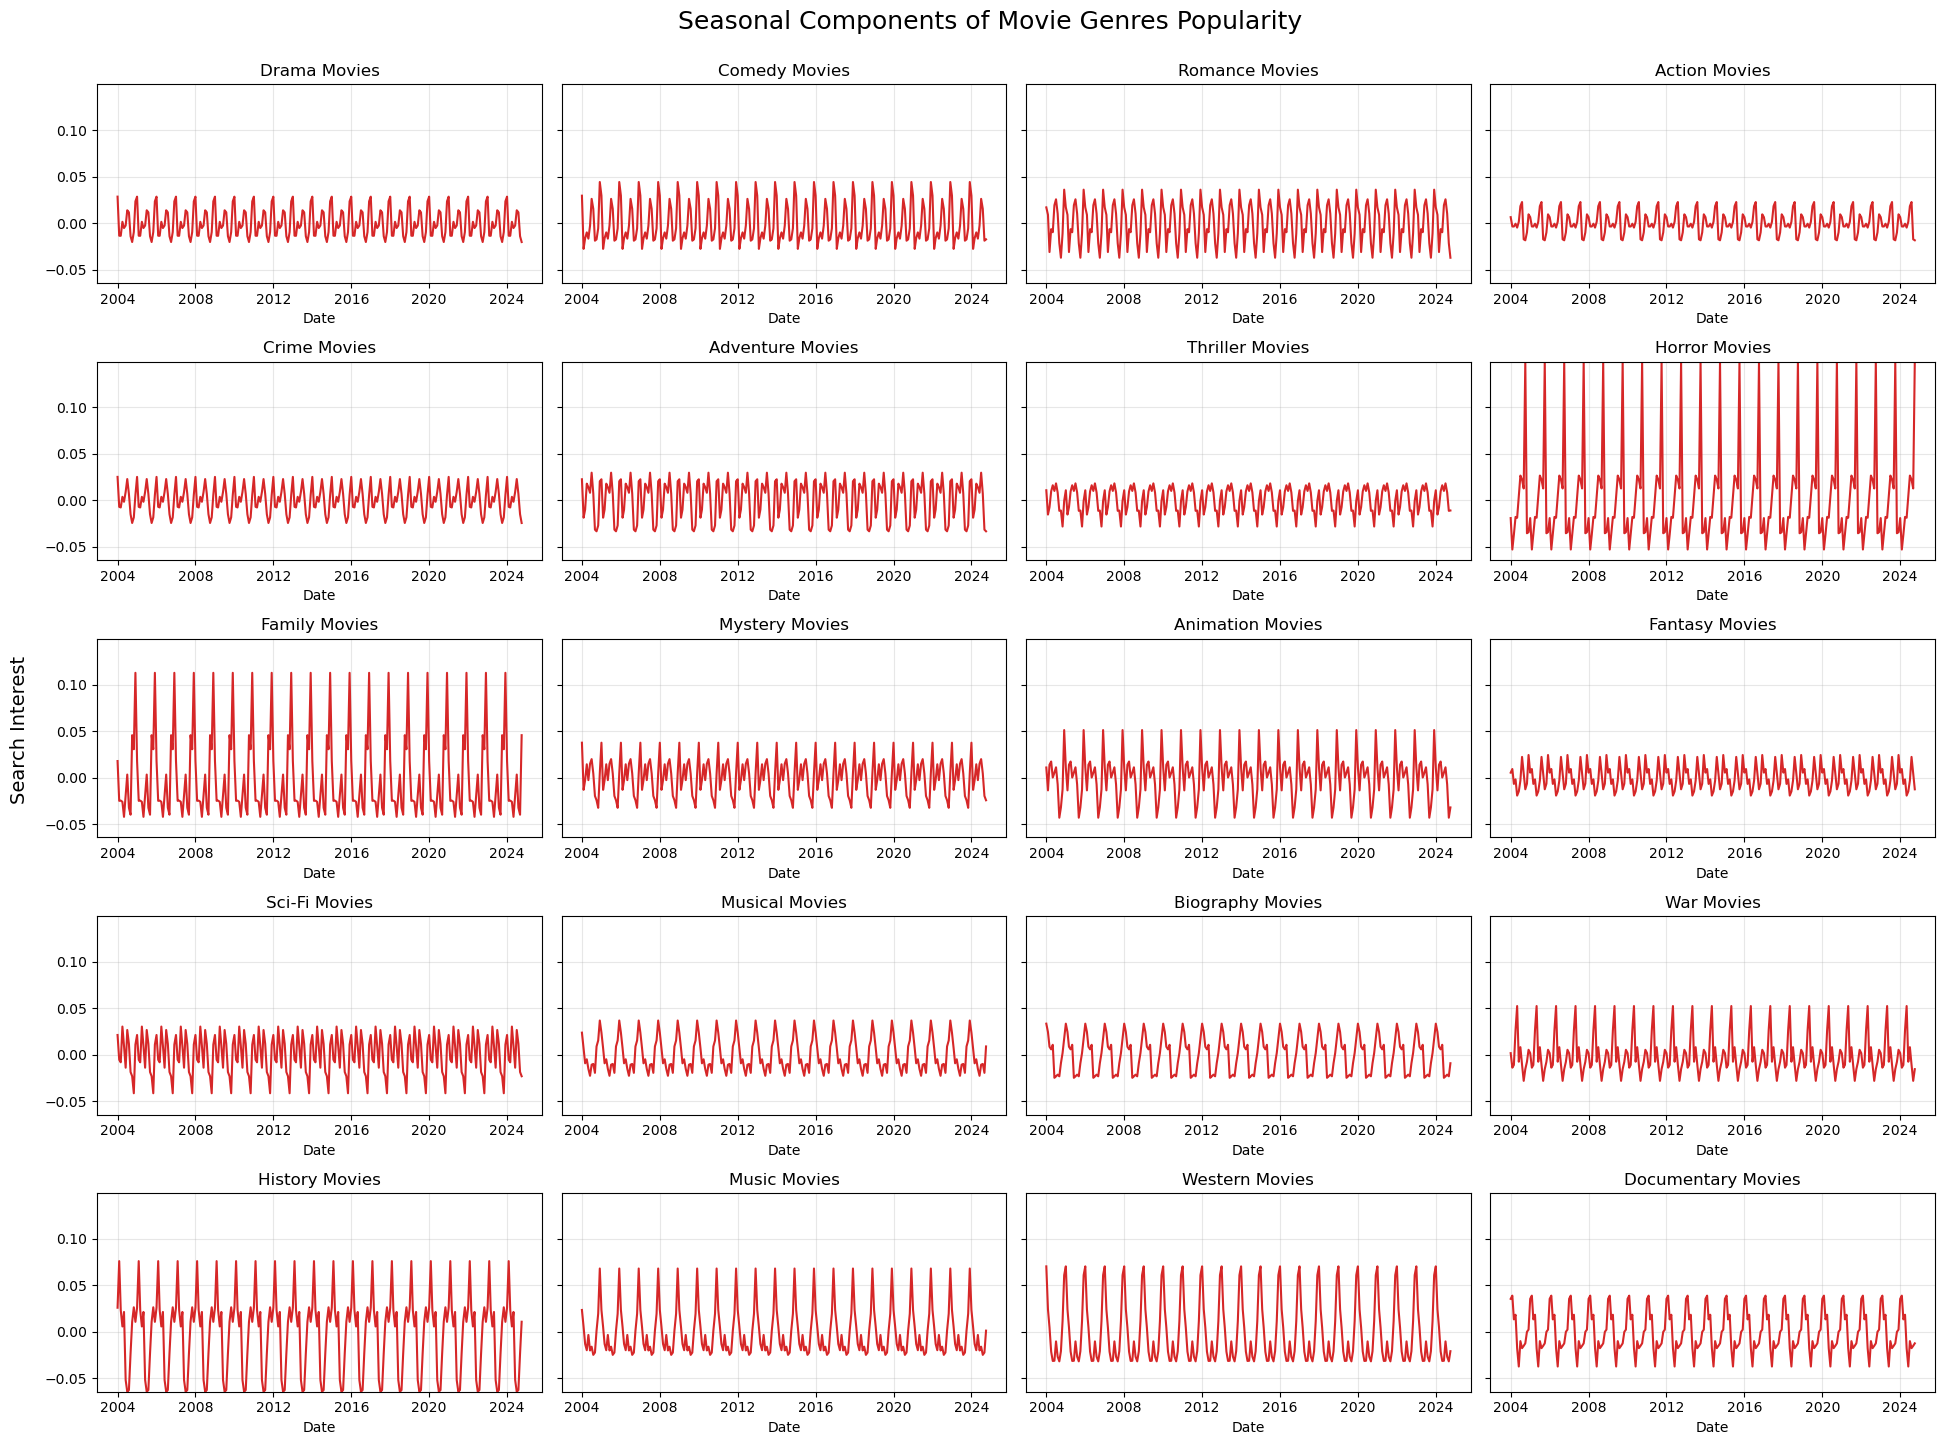

In [10]:
# Set up the subplots
fig, axes = plt.subplots(5, 4, figsize=(20, 15), sharey=True)
axes = axes.flatten()
y_min = min([decomposition.seasonal.min() for decomposition in genre_decompositions.values()])
y_max = max([decomposition.seasonal.max() for decomposition in genre_decompositions.values()])

# Plot each genre's seasonal component
for i, genre in enumerate(genres):
    decomposition = genre_decompositions[genre]
    axes[i].plot(decomposition.seasonal, label='Seasonality', color='tab:red')
    axes[i].set_title(f'{genre} Movies')
    axes[i].set_xlabel('Date')
    axes[i].grid(alpha=0.3)
    axes[i].set_ylim(y_min, y_max)

# Set a common y axis label
fig.text(0.01, 0.5, 'Search Interest', va='center', rotation='vertical', fontsize=14)

# Adjust layout
fig.suptitle('Seasonal Components of Movie Genres Popularity', fontsize=18)
plt.tight_layout(rect=[0.02, 0.02, 0.98, 0.98])
plt.show()

This analysis also uncovers the trend for each genre. 

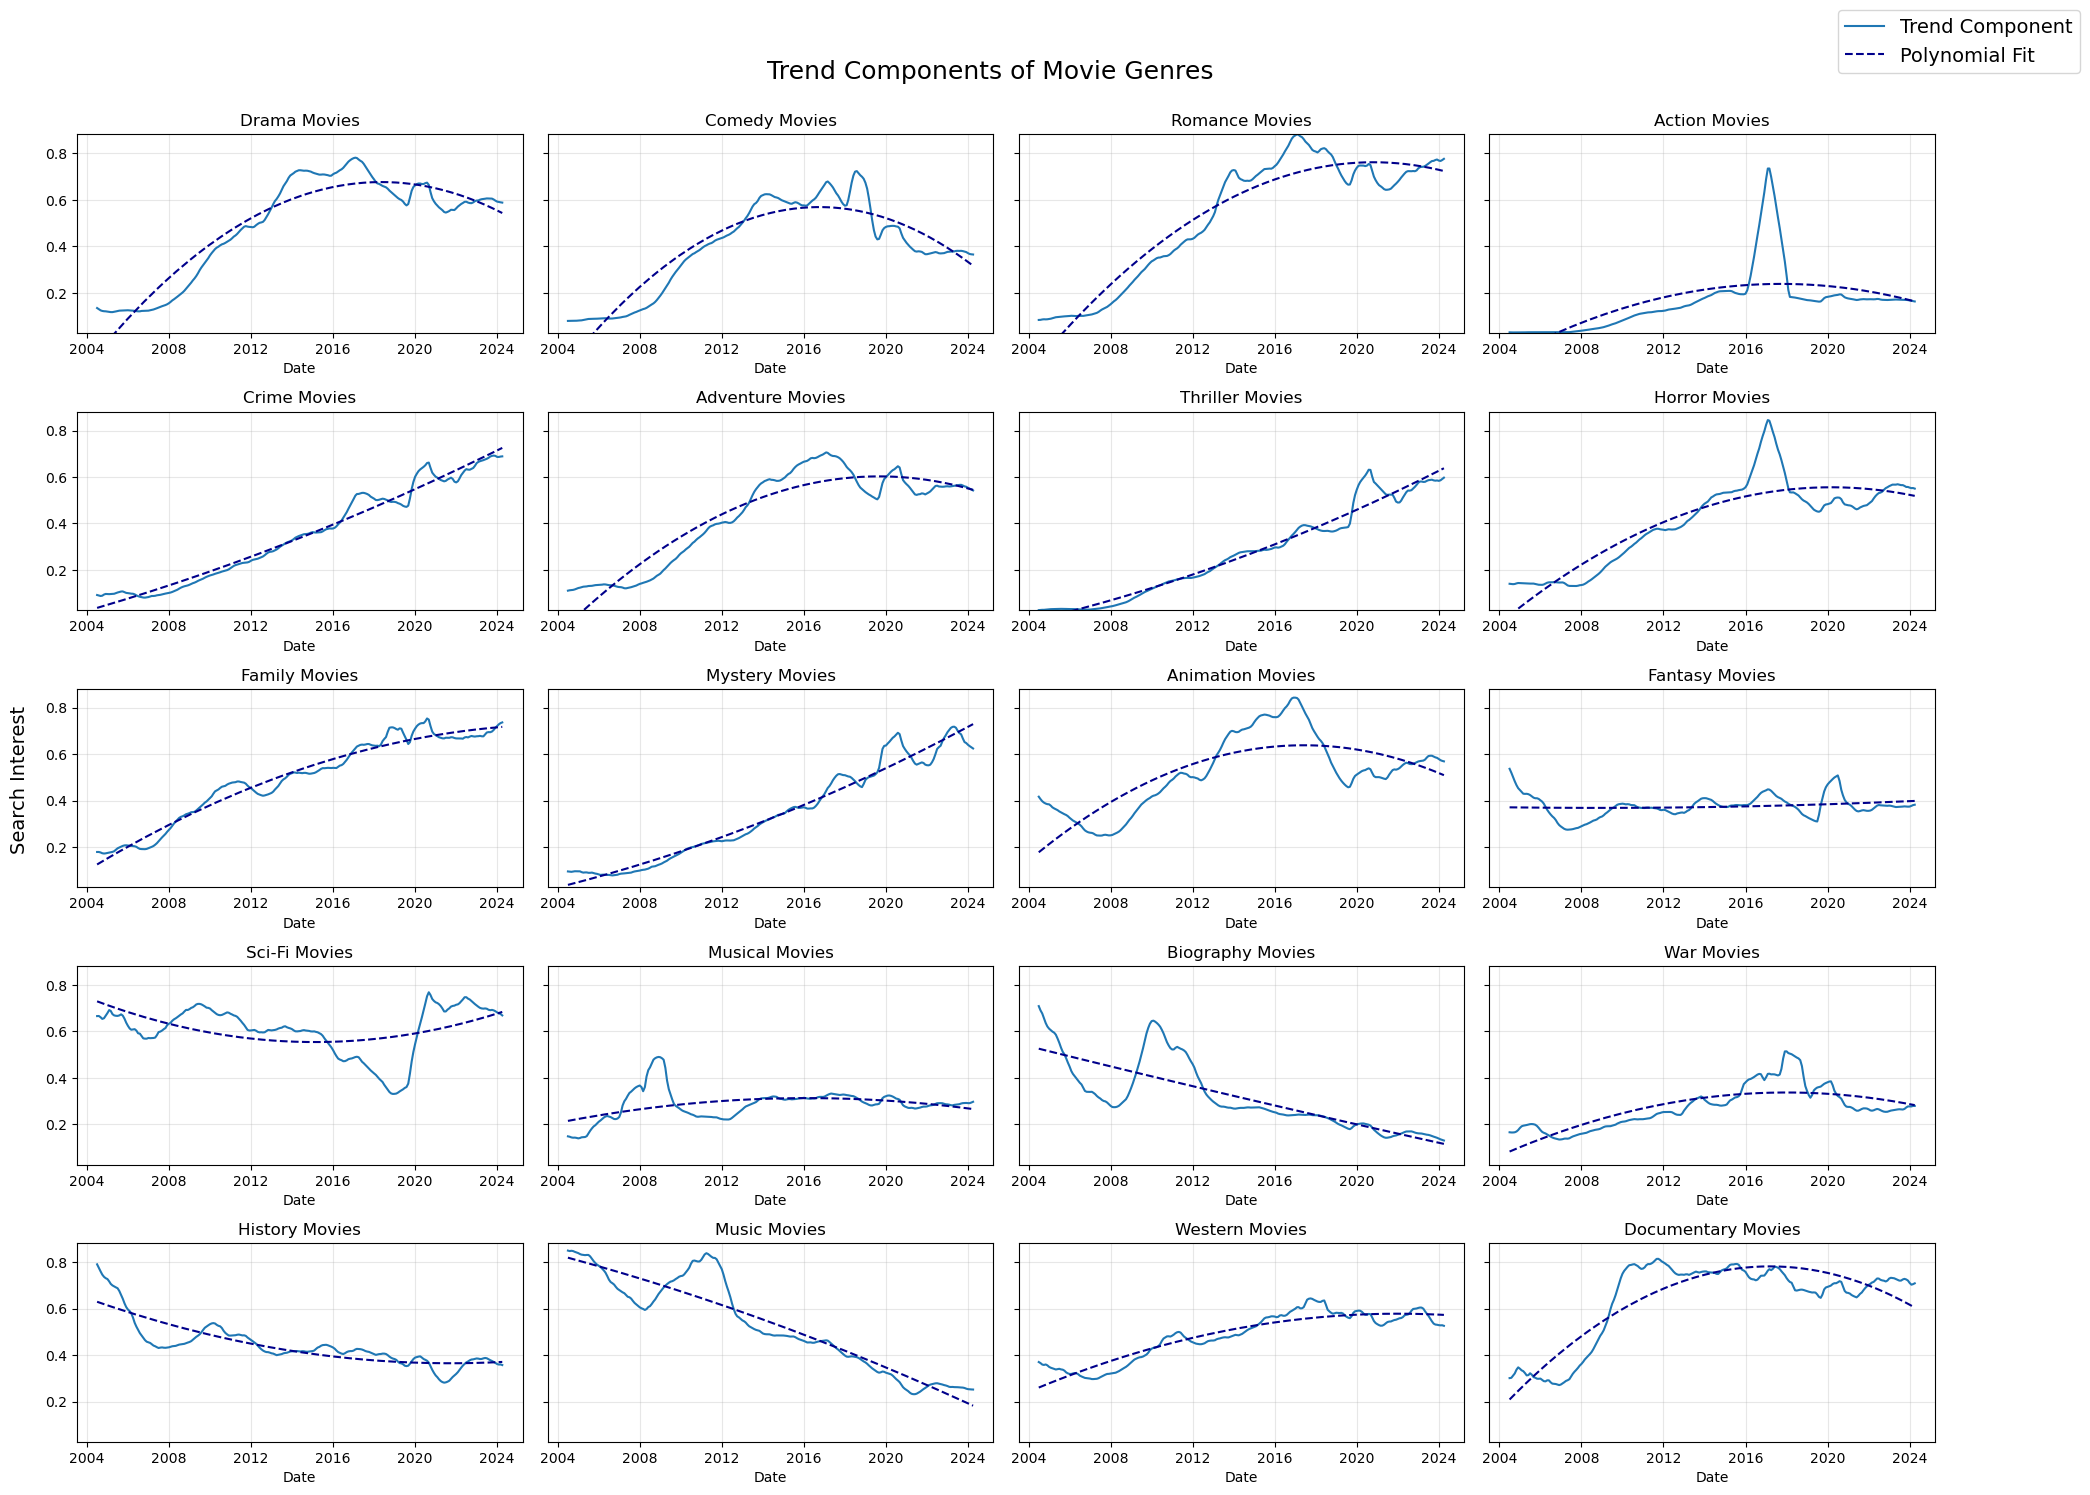

In [11]:
fig, axes = plt.subplots(5, 4, figsize=(20, 15), sharey=True)
axes = axes.flatten()

# Get a unified y-axis range for the trend component
y_min = min([decomposition.trend.min() for decomposition in genre_decompositions.values()])
y_max = max([decomposition.trend.max() for decomposition in genre_decompositions.values()])

# Plot each genre's trend component
for i, genre in enumerate(genres):
    decomposition = genre_decompositions[genre]
    trend = decomposition.trend.dropna()

    axes[i].set_title(f'{genre} Movies')
    axes[i].set_xlabel('Date')
    axes[i].grid(alpha=0.3)
    axes[i].set_ylim(y_min, y_max)

    x = trend.index.map(lambda date: date.toordinal())
    y = trend.values

    # Fit a polynomial regression of degree 2
    coefficients = np.polyfit(x, y, deg=2)
    polynomial = np.poly1d(coefficients)

    # Generate fitted values for the polynomial line
    x_fit = np.linspace(x.min(), x.max(), 200)
    y_fit = polynomial(x_fit)

    # Plot the trend component
    axes[i].plot(trend.index, y, label='Trend', color='tab:blue')

    # Plot the polynomial regression line
    axes[i].plot([pd.Timestamp.fromordinal(int(val)) for val in x_fit], y_fit, color='darkblue', linestyle='--')
    
# Set a common y axis label
fig.text(0.01, 0.5, 'Search Interest', va='center', rotation='vertical', fontsize=14)

# Adjust layout
fig.suptitle('Trend Components of Movie Genres', fontsize=18)
plt.tight_layout(rect=[0.02, 0.02, 0.98, 0.98])

# Plot a large legend outside of the subplots
handles = [plt.Line2D([0], [0], color='tab:blue', label='Trend Component'),
           plt.Line2D([0], [0], color='darkblue', linestyle='--', label='Polynomial Fit',)]
fig.legend(handles=handles, loc='upper right', bbox_to_anchor=(1.05, 1.02), fontsize=14, frameon=True)
plt.show()

Taking all these considerations into account, we can nonetheless observe clear shifts in popularity of certain genres. Are these fluctuations related to the number of movies released during the years? To answer this, we will have to restrict ourselves in movies data availability period which overlaps with available Google Search Trends Data for years 2004-2012.

### 3. Comparing movie releases and genre popularity

In [12]:
results_df = genres_vs_interest_correlation(movies, all_trends, genres)

c:\Users\aidas\ada-2024-project-americandentalassociation\src\utils\genres.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trends_filtered['Year'] = trends_filtered['date'].dt.year


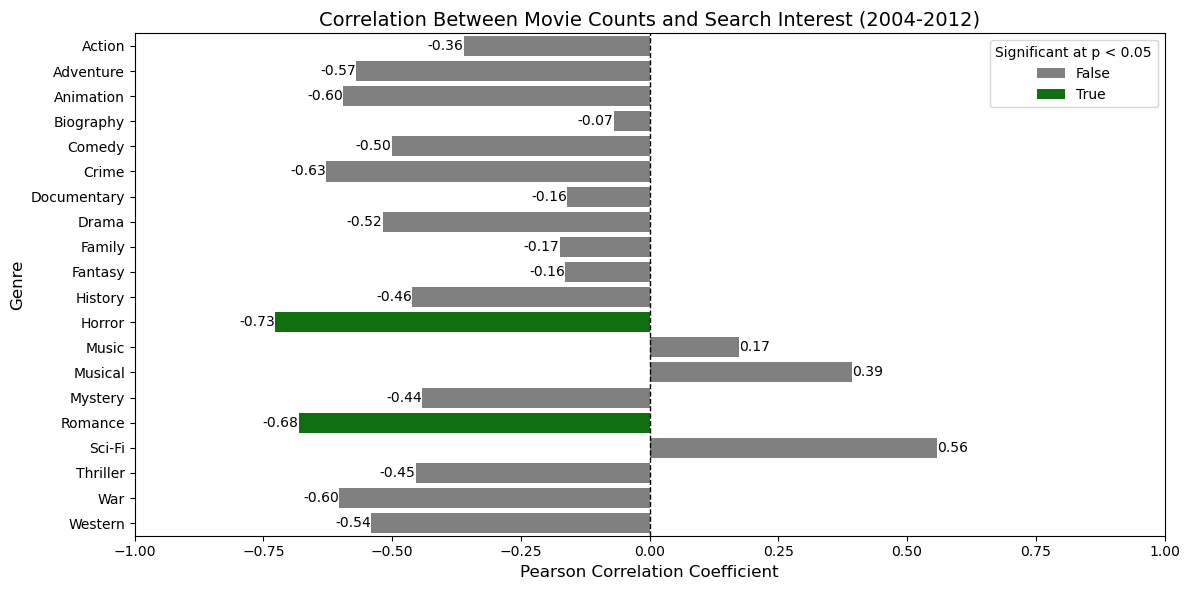

In [13]:
# Visualize the correlations
plt.figure(figsize=(12, 6))
sns.barplot(
    data=results_df.sort_values('Correlation', ascending=False),
    x='Correlation',
    y='Genre',
    hue=(results_df['P-Value'] < 0.05),
    dodge=False,
    palette={True: 'green', False: 'gray'}
)

# Show the correlation values
for i, row in results_df.iterrows():
    plt.text(row['Correlation'], i, f"{row['Correlation']:.2f}", va='center', ha= 'right' if row['Correlation'] < 0 else 'left')

# Set the x-axis limits
plt.xlim(-1, 1)

# Add labels and title
plt.title('Correlation Between Movie Counts and Search Interest (2004-2012)', fontsize=14)
plt.xlabel('Pearson Correlation Coefficient', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.legend(title='Significant at p < 0.05')
plt.tight_layout()
plt.show()

### 4. Estimating the impact of global events on movie genre popularity

In [14]:
# Fetch relevant data
events = pd.read_csv("data/events.csv")
all_trends = pd.read_csv('data/genre_trends.csv')

In [15]:
events_monthly, trends_monthly = gt.get_events_trends_monthly(events, all_trends)

c:\Users\aidas\ada-2024-project-americandentalassociation\src\utils\google_trends.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_filtered['Month'] = events_filtered['date'].dt.to_period('M').astype(str)
c:\Users\aidas\ada-2024-project-americandentalassociation\src\utils\google_trends.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trends_filtered['Month'] = trends_filtered['date'].dt.to_period('M').astype(str)


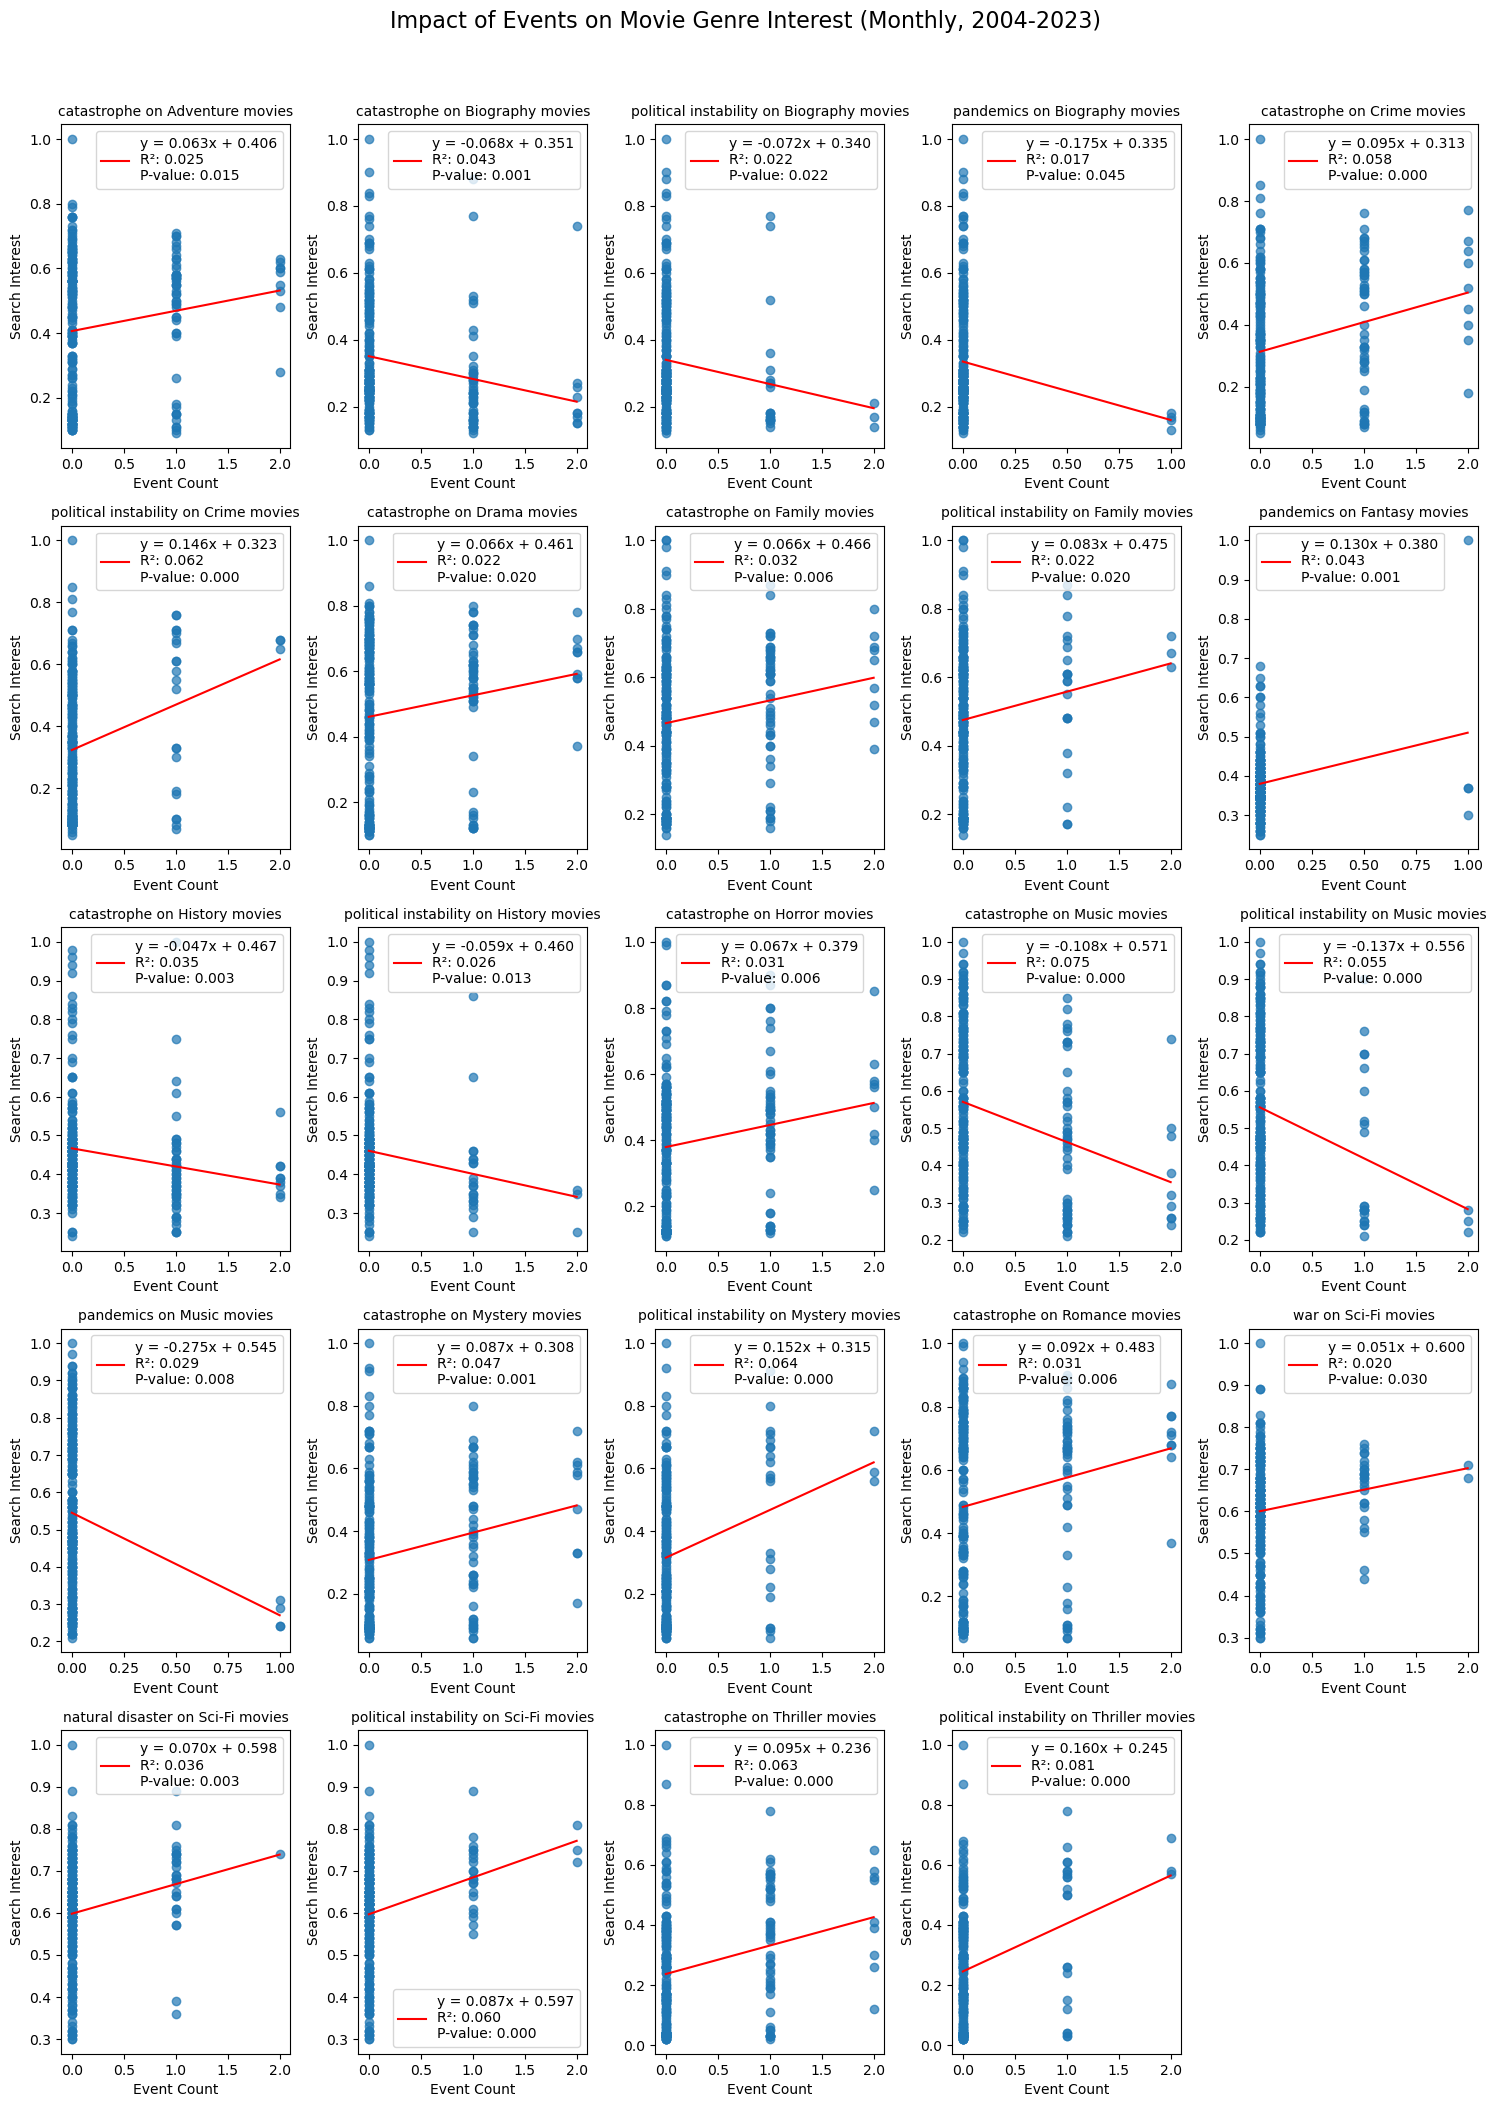

In [16]:
regression_df = regression_analysis(events_monthly, trends_monthly)

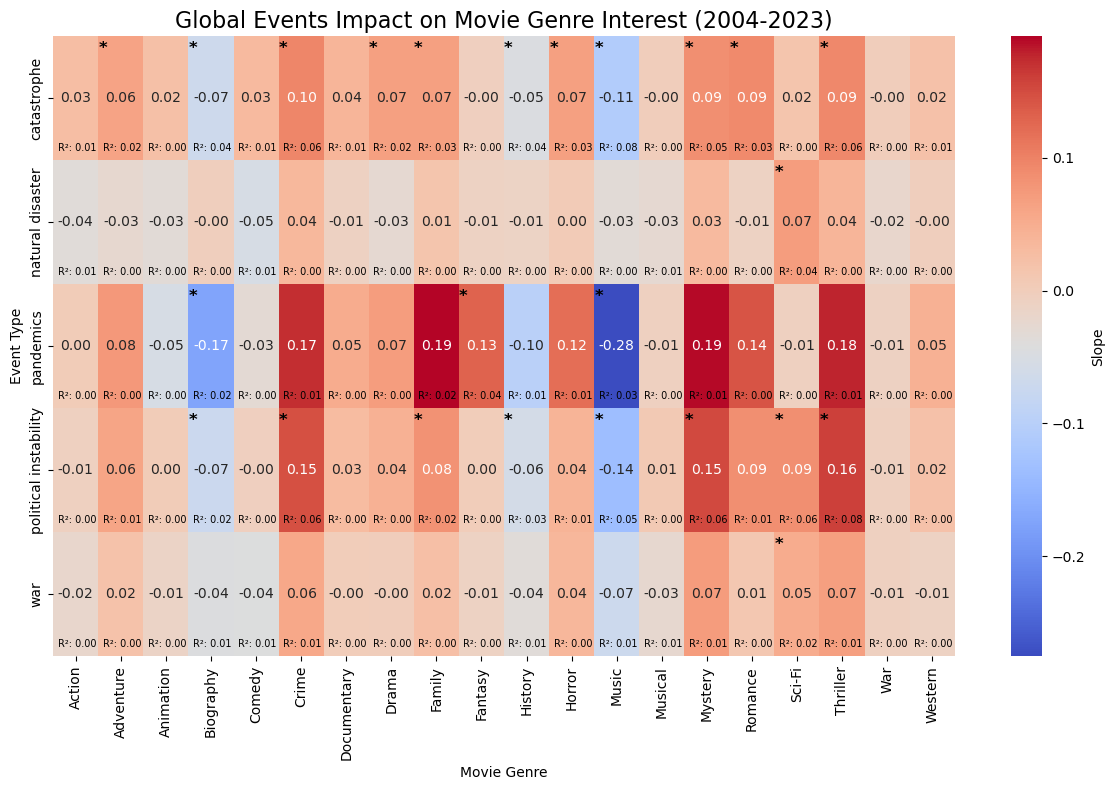

In [18]:
# Pivot the data to create a matrix of slopes for heatmap
heatmap_data = regression_df.pivot_table(index='event_type', columns='genre', values='slope')

# Create a heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".2f", cbar_kws={'label': 'Slope'})

# Add R-squared values to the heatmap
for i in range(len(regression_df)):
    event_type = regression_df.iloc[i]['event_type']
    genre = regression_df.iloc[i]['genre']
    r_squared = regression_df.iloc[i]['r_squared']
    
    # Get the numeric indices for event_type and genre
    event_type_idx = heatmap_data.index.get_loc(event_type)
    genre_idx = heatmap_data.columns.get_loc(genre)
    
    ax.text(genre_idx + 0.1, event_type_idx + 0.9, f'R²: {r_squared:.2f}', ha='left', va='center', fontsize=7)

# Mark statistical significance
for i in range(len(regression_df)):
    if regression_df.iloc[i]['p_value'] < 0.05:
        event_type = regression_df.iloc[i]['event_type']
        genre = regression_df.iloc[i]['genre']
        
        # Get the numeric indices for event_type and genre
        event_type_idx = heatmap_data.index.get_loc(event_type)
        genre_idx = heatmap_data.columns.get_loc(genre)
        
        # Add significance marker
        ax.text(genre_idx + 0.1, event_type_idx + 0.1, '*', color='black', ha='center', va='center', fontweight='bold', fontsize=12)

plt.title("Global Events Impact on Movie Genre Interest (2004-2023)", fontsize=16)
plt.xlabel("Movie Genre")
plt.ylabel("Event Type")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### 5. Analyzing short term impact of war events

Moving to the short term trends, in face of starting wars, can we observe a short term impact on audience preferences? To answer this question, we will inspect the popularity of war and historical movies around the period when wars started.

In [19]:
events = pd.read_csv("data/events.csv")

In [20]:
# Filter all wars for the period 2004-2012
wars = events[events['event_type'] == 'war']
wars_filtered = wars[(wars['date'] >= '2004-01-01') & (wars['date'] <= '2023-12-31')]

# Filter out the events which indicate an end of a war
wars_filtered = wars_filtered[(~wars_filtered['description'].str.contains('ends', case=False)) & ~(wars_filtered['description'].str.contains('end', case=False))]

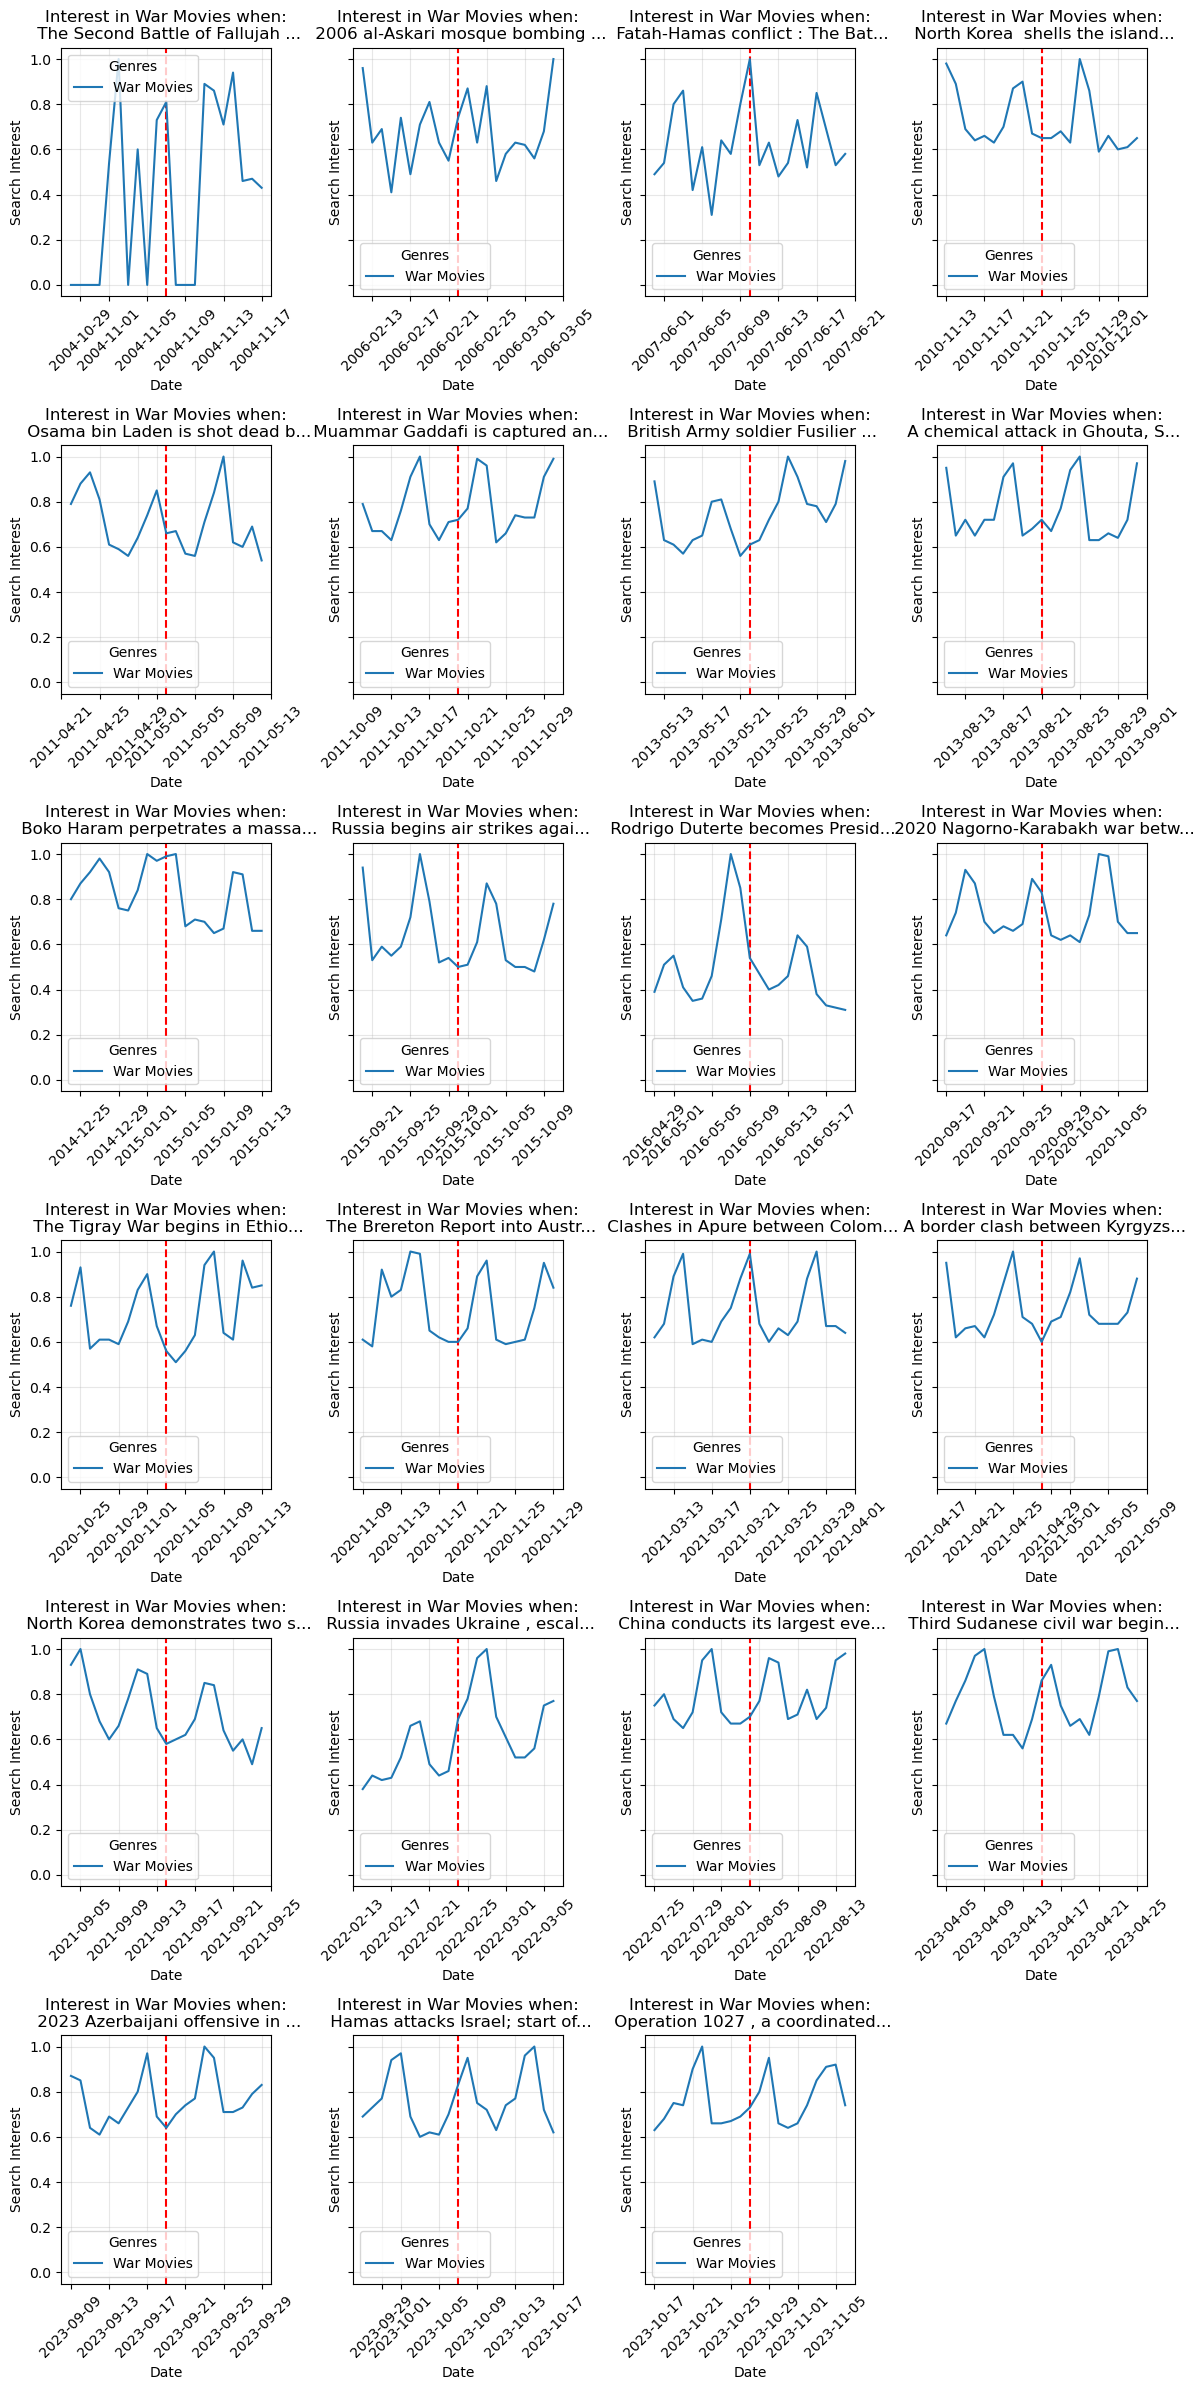

In [21]:
cols = 4
rows = (len(wars_filtered) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows), sharey=True)
axes = axes.flatten()

# Loop through each war event
for i, (index, war) in enumerate(wars_filtered.iterrows()):
    date = war['date']
    description = war['description']

    # Select the appropriate subplot
    ax = axes[i]

    ax.axvline(pd.to_datetime(date), color='red', linestyle='--', linewidth=1.5)

    # Fetch the search interest around the date
    trend = gt.query_interest_around_date("war movies", date)

    # Plot the trend value over time
    ax.plot(trend['date'], trend['value'], label="War Movies")

    # Set titles and labels for each subplot
    ax.set_title(f'Interest in War Movies when:\n {description.split(".")[0][:30]}{"..." if len(description) > 25 else ""}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Search Interest')

    # Add labels and legend
    ax.legend(title='Genres')
    ax.grid(alpha=0.3)

    # Rotate x-axis labels
    ax.tick_params(axis='x', rotation=45)

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()